## Travel Time Prediction
Author: X.L <br>
Date: 09/17/2022

### Summary
#### In this data challenge, I have trained and built a XGB regression model that predicts travel time for rideshare applications given only limited information about the trip: starting and ending location coordinates and departure timestamp. The model achieved 25% lower RMSE than the benchmark Linear Regression model with a RMSE of around 300 secs on a hold-out validate dataset.
#### While the accuracy of the model can definitely be improved given more features and more time for the project, I believe the results are already showing good promise for real application purposes and some of the methodologies employed here are transferable when solving real problems at Lyft.


In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

### Step 0: Data Import

In [2]:
train_df = pd.read_csv('train.csv')
#train_df.head()

test_df = pd.read_csv('test.csv')
#test_df.head()

print(f'training dataset shape: {train_df.shape}')
print(f'training dataset shape: {test_df.shape}')

combined = [train_df, test_df]

training dataset shape: (12089610, 7)
training dataset shape: (1868995, 6)


### Step 1: Data Exploration and Cleaning

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12089610 entries, 0 to 12089609
Data columns (total 7 columns):
 #   Column           Dtype  
---  ------           -----  
 0   row_id           int64  
 1   start_lng        float64
 2   start_lat        float64
 3   end_lng          float64
 4   end_lat          float64
 5   start_timestamp  int64  
 6   duration         int64  
dtypes: float64(4), int64(3)
memory usage: 645.7 MB


In [4]:
# check feature distributions
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
row_id,12089610.0,6.044804e+06,3.489970e+06,0.000000e+00,3.022402e+06,6.044804e+06,9.067207e+06,1.208961e+07
start_lng,12089610.0,-7.397391e+01,3.791707e-02,-7.451462e+01,-7.399212e+01,-7.398199e+01,-7.396779e+01,-7.341445e+01
start_lat,12089610.0,4.075057e+01,2.788033e-02,4.036892e+01,4.073687e+01,4.075344e+01,4.076780e+01,4.103142e+01
end_lng,12089610.0,-7.397364e+01,3.583265e-02,-7.451785e+01,-7.399148e+01,-7.398016e+01,-7.396357e+01,-7.341435e+01
end_lat,12089610.0,4.075133e+01,3.187935e-02,4.036887e+01,4.073541e+01,4.075396e+01,4.076889e+01,4.103151e+01
start_timestamp,12089610.0,1.432861e+09,7.543678e+06,1.420099e+09,1.426361e+09,1.432480e+09,1.439322e+09,1.446336e+09
duration,12089610.0,8.370984e+02,7.080951e+02,1.000000e+00,3.990000e+02,6.620000e+02,1.070000e+03,4.317800e+04


In [5]:
# check for nulls in the data
train_df.isnull().sum().T

row_id             0
start_lng          0
start_lat          0
end_lng            0
end_lat            0
start_timestamp    0
duration           0
dtype: int64

#### looks like there are no missing values we need to deal with and the start_lng, start_lat, end_lng, end_lat all have reasonable min and max values, so there are no needs to remove outliers for those features
#### However, the duration data does show a min of 1 sec which seems not quite reasonable and max of > 40000 secs (or > 10 hours) which is also quite weird. So I will look at ways to remove outliers for duration 

In [6]:
# Remove outliers for the 'duration' feature
train_df['duration'].apply(lambda x: np.log(x)).describe().T

count    1.208961e+07
mean     6.459299e+00
std      7.728929e-01
min      0.000000e+00
25%      5.988961e+00
50%      6.495266e+00
75%      6.975414e+00
max      1.067309e+01
Name: duration, dtype: float64

In [7]:
lower_bound = np.exp(6.46 - 3 * 0.77)
upper_bound = np.exp(6.46 + 3 * 0.77)
print(f'duration lower bound for outlier removal is estimated to be: {lower_bound}')
print(f'duration upper bound for outlier removal is estimated to be: {upper_bound}')

duration lower bound for outlier removal is estimated to be: 63.434000298123344
duration upper bound for outlier removal is estimated to be: 6438.1724643633315


#### Based on the above estimate, let's set the lower and upper bound for removing outliers of duration at 60 secs (1 min) and 7200 secs (2 hrs)`

In [8]:
## filtering the train_df in combined for durations within (60, 7200) secs.
df = combined[0]
combined[0] = df[(df['duration'] > 60) & (df['duration'] < 7200)]

### Step 2: Feature Engineering

#### Create Time Features

In [9]:
## convert the unix timestamp feature to date_time format
def convert_timestamp_to_datetime(df):
    df['start_datetime'] = pd.to_datetime(df['start_timestamp'], unit='s')
    
for df in combined:
    convert_timestamp_to_datetime(df)

In [10]:
# create hour of day, day of week, day of month features
for df in combined:
    df['start_date'] = df['start_datetime'].dt.date
    df['hour'] = df['start_datetime'].dt.hour
    df['day_of_week'] = df['start_datetime'].dt.weekday + 1
    df['day_of_month'] = df['start_datetime'].dt.day
    df['month_of_year'] = df['start_datetime'].dt.month
    df.drop('start_timestamp', axis=1, inplace=True)
    df.drop('start_datetime', axis=1, inplace=True)

In [11]:
## create a holiday feature column
holidays2015 = {
    "New Years Day": datetime.datetime(2015,1,1).date(),
    "Martin Luther King Day": datetime.datetime(2015,1,19).date(),
    "Easter Saturday": datetime.datetime(2015,4,4).date(),
    "Easter Sunday": datetime.datetime(2015,4,5).date(),
    "Memorial Sunday": datetime.datetime(2015,5,24).date(),
    "Memorial Day": datetime.datetime(2015,5,25).date(),
    "Independence Pre-day": datetime.datetime(2015,7,3).date(),
    "Independence Day": datetime.datetime(2015,7,4).date(),
    "Independence Post-day": datetime.datetime(2015,7,5).date(),
    "Labor Day": datetime.datetime(2015,9,7).date(),
    "Thanksgiving Day": datetime.datetime(2015,11,26).date(),
    "Thanksgiving Post-day": datetime.datetime(2015,11,27).date(),
    "Thanksgiving Post-post-day": datetime.datetime(2015,11,28).date(),
    "Christmas Eve": datetime.datetime(2015,12,24).date(),
    "Christmas Day": datetime.datetime(2015,12,25).date(),
    "Christmas Post-day": datetime.datetime(2015,12,26).date(),
    "New Years Eve": datetime.datetime(2015,12,31).date(),
}

for df in combined:
    df['holiday'] = 0
    for holiday in holidays2015.values():
        df.loc[df['start_date'] == holiday, 'holiday'] = 1


#### Create Distance Features

In [12]:
## compute haversine distances from coords
import math

def haversine(lat1, lon1, lat2, lon2):
     
    # distance between latitudes
    # and longitudes
    dLat = (lat2 - lat1) * math.pi / 180.0
    dLon = (lon2 - lon1) * math.pi / 180.0
 
    # convert to radians
    lat1 = (lat1) * math.pi / 180.0
    lat2 = (lat2) * math.pi / 180.0
 
    # apply formulae
    a = (pow(math.sin(dLat / 2), 2) +
         pow(math.sin(dLon / 2), 2) *
             math.cos(lat1) * math.cos(lat2));
    rad = 6371
    c = 2 * math.asin(math.sqrt(a))
    return rad * c

for df in combined:
    df['distance'] = df.apply(lambda x: haversine(x['start_lat'], x['start_lng'], x['end_lat'], x['end_lng']), axis=1)


# filter for distance > 0 miles
for i, df in enumerate(combined):
    combined[i] = df[df['distance'] > 0]

combined_df = pd.concat(combined)
#combined_df.head()

combined_df.shape

(13834856, 13)

In [38]:
print(f"The range of dates availabe in the training and testing data are: {combined_df['start_date'].min()} - {combined_df['start_date'].max()}")

The range of dates availabe in the training and testing data are: 2015-01-01 - 2015-12-19


#### （Scrapped）Create Neighborhood Feature from OpenStreetMap (NOTE: API call took too long)

In [13]:
# import requests
# def get_neighborhood_info(lat, lng):
#     # use openstreetmap to get address information from location latitude and longitude
#     url = "http://nominatim.openstreetmap.org/reverse?format=json&lat={lat}&lon={lng}&addressdetails=1"
#     response = requests.get(url.format(lat=lat, lng=lng))
#     try:
#         nh =response.json()['address']['neighbourhood']
#     except:
#         nh = None
#     return nh
    

# df_sample = combined_df.sample(frac=0.0001)[:500]
# df_sample['neighborhood'] = df_sample.apply(lambda x: get_neighborhood_info(x['start_lat'], x['start_lng']), axis=1)

#### Use DBCAN to find location clusters

In [14]:
# use DBSCAN to find location clusters
from sklearn.cluster import DBSCAN
from matplotlib.patches import Rectangle

def find_cluster_boundaries(combined_df):
    ## get all coords (both starting location and ending location) into one dataframe: all_coords
    all_coords = pd.concat([combined_df[['start_lng', 'start_lat']].rename(columns={'start_lng': 'lng', 'start_lat': 'lat'}), 
                            combined_df[['end_lng', 'end_lat']].rename(columns={'end_lng': 'lng', 'end_lat': 'lat'})], axis=0)
    ## sample 1% for DBSCAN clustering
    df_sample = all_coords.sample(frac=0.01, random_state=42).reset_index(drop=True)
    ## fit DBSCAN on sampled data
    DB = DBSCAN(eps=0.005, min_samples=2500).fit(df_sample)

    print(f'number of clusters: {max(DB.labels_) + 1}')

    df_sample['cluster_label']= DB.labels_
    cluster_centers = df_sample.loc[DB.core_sample_indices_, :].groupby('cluster_label').agg(['mean', 'std']).reset_index()
    cluster_centers = cluster_centers.T.reset_index(drop=True).T
    cluster_centers.columns = ['cluster_label', 'lng_mean', 'lng_std', 'lat_mean', 'lat_std']
    # creating the bounding window for each cluster found by DBSCAN
    cluster_centers['lng_lb'] = cluster_centers['lng_mean'] - 3 * cluster_centers['lng_std']
    cluster_centers['lng_ub'] = cluster_centers['lng_mean'] + 3 * cluster_centers['lng_std']
    cluster_centers['lat_lb'] = cluster_centers['lat_mean'] - 3 * cluster_centers['lat_std']
    cluster_centers['lat_ub'] = cluster_centers['lat_mean'] + 3 * cluster_centers['lat_std']

    return df_sample, cluster_centers

# df_sample, cluster_centers = find_cluster_boundaries(combined_df)

def plot_locations_and_clusters(df_sample, cluster_centers):
    fig, ax = plt.subplots(figsize=(12, 10))
    plt.scatter(df_sample['lng'], df_sample['lat'], marker='o', alpha=0.05)
    colors = ['red', 'green', 'orange']
    for i in range(3):
        plt.scatter(cluster_centers.loc[i, 'lng_mean'], cluster_centers.loc[i, 'lat_mean'], s=500, c=colors[i], label = 'cluster_' + str(i), marker='.')
    plt.legend()
    # plt.scatter(cluster_centers['lng_mean'], cluster_centers['lat_mean'], s=1000, c=cluster_centers['cluster_label'], marker='.')
    # rect = plt.Rectangle((-74, 40.6), 1, 1, ls="--", ec="c", fc="none")
    # ax.add_patch(rect)
    for i in range(3):
        rect = Rectangle((cluster_centers.loc[i, 'lng_lb'], cluster_centers.loc[i, 'lat_lb']), 
                  6 * cluster_centers.loc[i, 'lng_std'], 
                  6 * cluster_centers.loc[i, 'lat_std'],
                  ls="--", ec="k", fc="none")
        ax.add_patch(rect)
    #plt.scatter(cluster_centers['lng_ub'], cluster_centers['lat_ub'], s=100, c=cluster_centers['cluster_label'], marker='D')
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.title('New York Pick-up/Drop-off location Density and DBSCAN Cluster Centers')
    plt.show()

number of clusters: 3


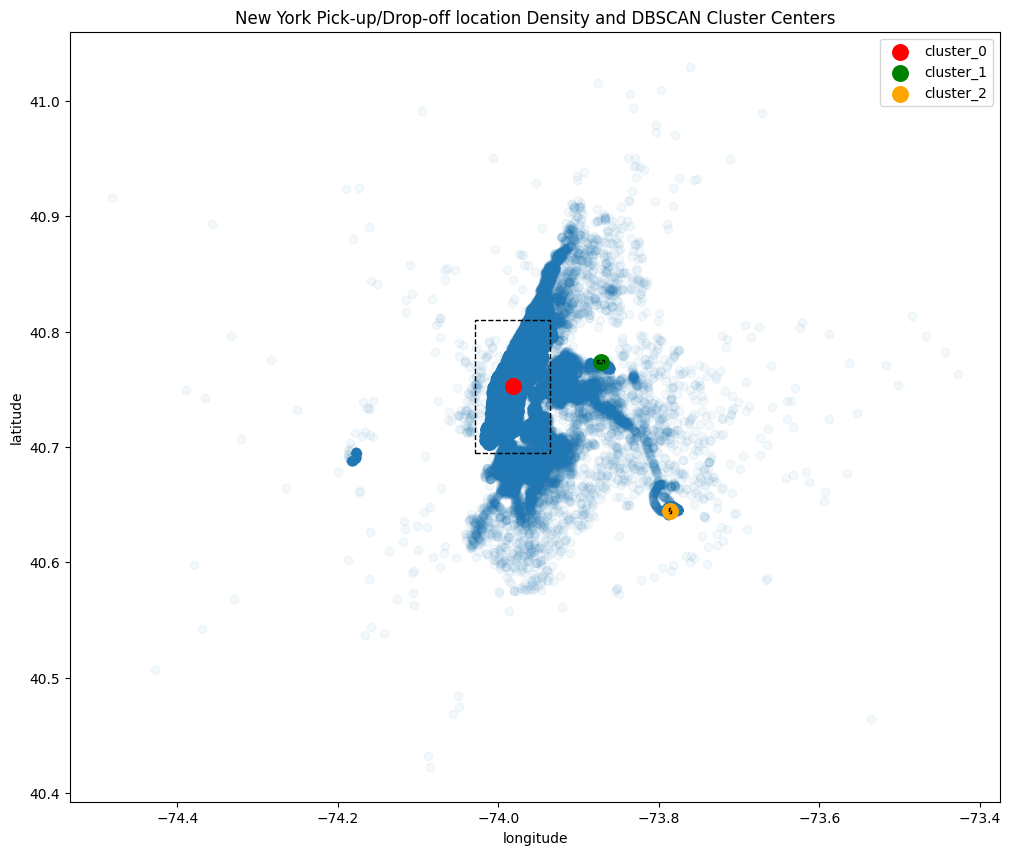

In [15]:
df_sample, cluster_centers = find_cluster_boundaries(combined_df)
plot_locations_and_clusters(df_sample, cluster_centers)

#### looking at the graph, it appears to me that cluster_0 is bascially City Center, cluster_1 is LaGuardia Airport and cluster_2 is JFK Airport 
#### Note: because of the training data is too big for DBSCAN clustering, I sampled 1% from all combined data for this clustering. To assign clusters to all data, here is my approach: 
1. I have created a few rectangles around the cluster centers (+/- 3 standard deviations of each cluster) <br>
2. for the raw data, will create two new features marking whether the starting and ending locations are in each of the above 3 clusters by checking whether the coords fall into those rectangles, if not, it will be assigned 'other' for cluster labels. <br>

In [16]:
train_df = combined[0].sample(frac=0.01, random_state=42).reset_index(drop=True)

In [17]:
# create cluster_name given latitidue and longitude and a datafrom with cluster bounderies.
def assign_geolocation_cluster(lat, lng, cluster_centers):
    cluster_names = {0: 'City_Center', 1: 'LaGuardia_Airport', 2: 'JFK_Airport'}
    
    for i in range(len(cluster_centers)):
        if (cluster_centers.loc[i, 'lng_lb'] <= lng <= cluster_centers.loc[i, 'lng_ub']) & \
            (cluster_centers.loc[i, 'lat_lb'] <= lat <= cluster_centers.loc[i, 'lat_ub']):
                return cluster_names[i]
    
    return 'Other'

# perform one-hot-encoding for the location cluster features:
def create_one_hot_encoded_loc_clusters(train_df):
    for loc_type in ('start', 'end'):
        for location in train_df[loc_type + '_location_cluster'].unique():
            if location != 'Other':
                train_df[loc_type + '_' + location] = 0
                train_df.loc[train_df[loc_type + '_location_cluster']==location, loc_type + '_' + location] = 1
        
        train_df = train_df.drop(loc_type + '_location_cluster', axis=1)
        
    return train_df

# create one-hot-encoded location cluster features.
def create_location_cluster_features(df, cluster_centers):
    for loc_type in ('start', 'end'):
        df[loc_type + '_location_cluster'] = df.apply(lambda x: assign_geolocation_cluster(x[loc_type + '_lat'], x[loc_type + '_lng'], cluster_centers), axis=1)
        
    df = create_one_hot_encoded_loc_clusters(df)
    return df

In [18]:
train_df = create_location_cluster_features(train_df, cluster_centers)

In [19]:
train_df.head()

,row_id,start_lng,start_lat,end_lng,end_lat,duration,start_date,hour,day_of_week,day_of_month,month_of_year,holiday,distance,start_City_Center,start_LaGuardia_Airport,start_JFK_Airport,end_City_Center,end_LaGuardia_Airport,end_JFK_Airport
0,12006525,-73.985008,40.745682,-73.974487,40.754822,719,2015-10-29,20,4,29,10,0,1.348467,1,0,0,1,0,0
1,94476,-73.962151,40.766800,-73.950943,40.772488,438,2015-01-26,20,1,26,1,0,1.136172,1,0,0,1,0,0
2,1322864,-73.994621,40.755539,-74.003456,40.743553,240,2015-01-27,1,2,27,1,0,1.526501,1,0,0,1,0,0
3,5437167,-73.947701,40.775051,-73.975159,40.760151,1041,2015-04-24,22,5,24,4,0,2.844660,1,0,0,1,0,0
4,11904192,-73.991142,40.755909,-73.990562,40.761791,205,2015-10-26,19,1,26,10,0,0.655870,1,0,0,1,0,0


#### Create Weather Features

In [20]:
# Note that the weather data was downloaded from NOAA for NYC for the entire year of 2015
def add_weather_features(df):
    weather = pd.read_csv('nyc_2015_weather.csv')
    weather = weather[['DATE', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN']]
    #weather.describe().T

    weather['hot_day'] = weather.apply(lambda x: int(x['TMAX'] > 90), axis=1)
    weather['cold_day'] = weather.apply(lambda x: int(x['TMIN'] < 32), axis=1)
    weather.head()

    weather['DATE'] = weather['DATE'].apply(lambda x : datetime.datetime.strptime(x, '%Y-%m-%d').date())
    #weather.info()

    df = df.merge(weather, left_on='start_date', right_on='DATE', how='left')
    #train_df.head()

    df = df.drop(['DATE', 'TMAX', 'TMIN'], axis=1)
    
    return df

In [21]:
train_df = add_weather_features(train_df)

### Step 3: Modeling

#### Final Training Data

In [22]:
train_df.head()

,row_id,start_lng,start_lat,end_lng,end_lat,duration,start_date,hour,day_of_week,day_of_month,...,start_LaGuardia_Airport,start_JFK_Airport,end_City_Center,end_LaGuardia_Airport,end_JFK_Airport,PRCP,SNOW,SNWD,hot_day,cold_day
0,12006525,-73.985008,40.745682,-73.974487,40.754822,719,2015-10-29,20,4,29,...,0,0,1,0,0,0.04,0.0,0.0,0,0
1,94476,-73.962151,40.766800,-73.950943,40.772488,438,2015-01-26,20,1,26,...,0,0,1,0,0,0.48,5.5,2.0,0,1
2,1322864,-73.994621,40.755539,-74.003456,40.743553,240,2015-01-27,1,2,27,...,0,0,1,0,0,0.36,4.3,7.9,0,1
3,5437167,-73.947701,40.775051,-73.975159,40.760151,1041,2015-04-24,22,5,24,...,0,0,1,0,0,0.00,0.0,0.0,0,0
4,11904192,-73.991142,40.755909,-73.990562,40.761791,205,2015-10-26,19,1,26,...,0,0,1,0,0,0.00,0.0,0.0,0,0


#### Create Training and Validation data

In [23]:
#train_df = combined[0].sample(frac=0.01)

#train_df['start_date'] = train_df['start_date'].astype('category')
X = train_df.drop(['row_id', 'duration', 'start_date'], axis=1)
y = train_df['duration']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#### Explore different models for travel time predictions

In [26]:
def travel_time_regression(X_train, X_val, y_train, y_val, model_name):
    RMSE = None
    model = None
    if model_name == 'Linear regression':
        model = LinearRegression(normalize=True)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        
        RMSE = np.sqrt(mean_squared_error(y_val, y_pred))
        print(f'{model} model gives a RMSE of {RMSE} with {len(X_train)} training data points')
        
    elif model_name == 'Ridge regression':
        model = Ridge(normalize=True, alpha=0.5)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        
        RMSE = np.sqrt(mean_squared_error(y_val, y_pred))
        print(f'{model} model gives a RMSE of {RMSE} with {len(X_train)} training data points')
    
    elif model_name == 'Lasso regression':
        model = Lasso(alpha=0.1, normalize=True, max_iter=5000)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        
        RMSE = np.sqrt(mean_squared_error(y_val, y_pred))
        print(f'{model} model gives a RMSE of {RMSE} with {len(X_train)} training data points')
    
    elif model_name == 'SVR':
        model = SVR()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        
        RMSE = np.sqrt(mean_squared_error(y_val, y_pred))
        print(f'{model} model gives a RMSE of {RMSE} with {len(X_train)} training data points')
        
    elif model_name == 'XGB regression':
        model = XGBRegressor(max_depth=9, learning_rate=0.05, n_estimators=500, reg_lambda=0.5)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        
        RMSE = np.sqrt(mean_squared_error(y_val, y_pred))
        print(f'{model} model gives a RMSE of {RMSE} with {len(X_train)} training data points')
        
    elif model_name == 'Random Forrest':
        model = RandomForestRegressor(max_depth=5, n_estimators=500, max_features=0.7)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        
        RMSE = np.sqrt(mean_squared_error(y_val, y_pred))
        print(f'{model} model gives a RMSE of {RMSE} with {len(X_train)} training data points')
    
    return model, RMSE
        

In [27]:
model_list = ['Linear regression', 'Ridge regression', 'Lasso regression', 'XGB regression', 'Random Forrest']

results = []

for model_name in model_list:
    results.append(travel_time_regression(X_train, X_val, y_train, y_val, model_name))
    


LinearRegression(normalize=True) model gives a RMSE of 406.36648184695713 with 95792 training data points
Ridge(alpha=0.5, normalize=True) model gives a RMSE of 443.66622667172413 with 95792 training data points
Lasso(alpha=0.1, max_iter=5000, normalize=True) model gives a RMSE of 414.57414666000426 with 95792 training data points
XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=9, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_

#### Looks like without much tuning the XGB Regressor gives the best performance with a RMSE of prediction of only 304 secs on the validatiuon data!
#### Now I will explore Hyperparameter tuning for XGB Regressor specificly and see if I can improve its performance further.

In [28]:
SKIP_HP_TUNING = True

#### XGB Regressor Hyperparameter tuning

In [29]:
if not SKIP_HP_TUNING:
    hp= {
        'max_depth': [7, 9, 11, 13],
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [500, 1000]
    }

    def XGB_regression_hp_tuning(X_train, X_val, y_train, y_val, hp):
        for max_depth in hp['max_depth']:
            for learning_rate in hp['learning_rate']:
                for n_estimators in hp['n_estimators']:
                    model = XGBRegressor(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators, reg_lambda=0.5)
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_val)
                    RMSE = np.sqrt(mean_squared_error(y_val, y_pred))
                    print(f'XGB regressor with max_depth: {max_depth}, learning_rate: {learning_rate}, n_estimators: {n_estimators} gives a RMSE of {RMSE} with {len(X_train)} training data points')

    XGB_regression_hp_tuning(X_train, X_val, y_train, y_val, hp)

#### Looks like max_depth: 9, learning_rate: 0.05, n_estimators: 1000 gives the best performance on the validation data with a RMSE of 303 secs

### Step 4: Final Model Training and Prediction

In [32]:
## Preprocess test data

test_df = combined[1]
#test_df.head()

test_df = create_location_cluster_features(test_df, cluster_centers)
test_df = add_weather_features(test_df)

#### Final test_df
test_df.head()

In [33]:
row_id = test_df['row_id']
test_df = test_df.drop(['row_id', 'start_date'], axis=1)

In [34]:
xgb_final = XGBRegressor(max_depth=9, learning_rate=0.05, n_estimators=1000, reg_lambda=0.5)
xgb_final.fit(X, y)
pred_test = xgb_final.predict(test_df)

In [35]:
pred_duration = pd.DataFrame({'row_id': row_id, 'duration': pred_test})
pred_duration.to_csv("duration.csv", index=False)